In [1]:
import pickle

with open('results.pkl','rb') as f:
    d = pickle.load(f)

In [2]:
rmaps = np.unique(out['roacc'].rmap)
rdmchis = np.unique(out['roacc'].rdmchi)

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

for rmap, rdmchi in cartesian_product(rmaps, rdmchis):
    print(rmap, rdmchi)

fig, axes = plt.subplots(
    nrows=len(rdmchis),
    ncols=len(rmaps),
    sharex = 'col',
    sharey = 'row',
    figsize = (7*len(rmaps),7*len(rdmchis)),
    gridspec_kw = dict(
        wspace = 0.05,
        hspace = 0.05
    )
)

for (rdmchi, rmap), ax in zip(
    cartesian_product(rdmchis, rmaps),
    axes.flatten()
):
    sl = out['roacc'][(
        (out['roacc'].rdmchi==rdmchi)
        &(out['roacc'].rmap==rmap)
    )]
    ax.scatter(sl.mchi[sl.full_rate==0.0], sl.eps2[sl.full_rate==0.0],
               color='gray')
    im = ax.scatter(sl.mchi, sl.eps2, c=sl.full_rate,
                    norm=mpl.colors.LogNorm(1e-4, 1e4),
                    cmap='RdYlGn')
    ax.set_yscale('log')

for rmap, ax in zip(rmaps, axes[0]):
    ax.set_title(f'$m_A = {rmap}m_\\chi$')

for irow, rdmchi in enumerate(rdmchis):
    axes[irow][0].set_ylabel(f'$\Delta = {rdmchi}m_\\chi$        $\epsilon^2$')
    
for ax in axes[2]:
    ax.set_xlabel('$m_\\chi$ [MeV]')

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Expected Events')
fig.savefig('plots/idm-reach-survey.pdf', bbox_inches='tight')
plt.show()

{'signal': {'roacc':         eps2  mchi  rdmchi  rmap  num_pass  num_thrown  reweightsum  \
  0   0.000001  50.0     0.6   2.6      2107     2000000     1.175040   
  1   0.000001  70.0     0.5   2.0       672     2000000     0.946827   
  2   0.000001  50.0     0.6   2.6      2107     2000000     1.404233   
  3   0.000001  70.0     0.5   2.0       672     2000000     1.114092   
  4   0.000001  50.0     0.6   2.6      2107     2000000     1.674823   
  ..       ...   ...     ...   ...       ...         ...          ...   
  95  0.006866  70.0     0.5   2.0       672     2000000     0.840515   
  96  0.008286  50.0     0.6   2.6      2107     2000000     6.797192   
  97  0.008286  70.0     0.5   2.0       672     2000000     0.551397   
  98  0.010000  50.0     0.6   2.6      2107     2000000     5.871072   
  99  0.010000  70.0     0.5   2.0       672     2000000     0.328612   
  
      reweightsum_pass     prod_rate      z_cut_eff  event_selection_eff  \
  0       3.605943e-01  6.

In [ ]:
rate_maxima = out['roacc'].groupby(['rdmchi','rmap','mchi']).full_rate.max().reset_index()

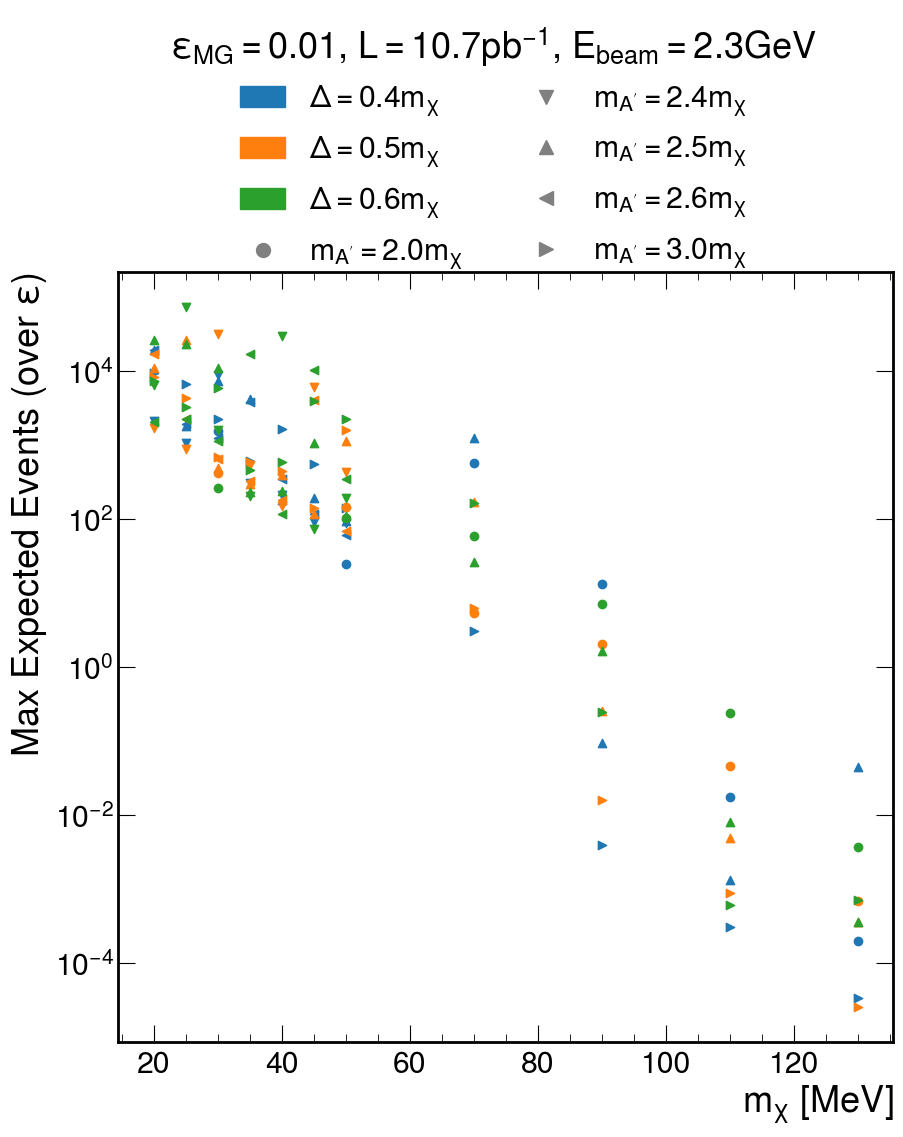

In [159]:
rdmchi = list(np.unique(rate_maxima.rdmchi))
rdmchi.sort()
colors = { r : c for r,c in zip(rdmchi, list(mpl.colors.TABLEAU_COLORS.keys())[:len(rdmchi)])}

rmaps = list(np.unique(rate_maxima.rmap))
rmaps.sort()
markers = { r : m for r, m in zip(rmaps, mpl.lines.Line2D.filled_markers[1:len(rmaps)+1]) }

# fig, axes = plt.subplots(
#     nrows = 2,
#     sharex = True,
#     gridspec_kw = dict(
#         hspace = 0,
#         bottom=0, top=1, left=0, right=1
#     )
# )
fig, ax = plt.subplots()

for rdmchi, color in colors.items():
    for rmap, marker in markers.items():
        sl=rate_maxima[(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)]
        if sum(sl.full_rate) == 0:
            continue
        ax.scatter(sl.mchi, sl.full_rate,
            color = color,
            marker = marker
        )
ax.set_yscale('log')

legend_artists = []
for rdmchi, color in colors.items():
    legend_artists.append(
        mpl.patches.Patch(
            facecolor=color, edgecolor=color, 
            label=f'$\\Delta = {rdmchi}m_\\chi$'
        )
    )
for rmap, marker in markers.items():
    legend_artists.append(
        mpl.lines.Line2D(
            [0],[0],
            marker = marker, color='gray', lw=0,
            markersize=10,
            label=f'$m_{{A\'}}={rmap}m_\\chi$'
        )
    )

fig.legend(
    title='$\\epsilon_\\mathrm{MG}=0.01$, $\\mathcal{L}=10.7\\mathrm{pb}^{-1}$, $E_\\mathrm{beam}=2.3$GeV',
    handles=legend_artists,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5,0.85)
)

ax.set_xlabel('$m_\\chi$ [MeV]')
ax.set_ylabel('Max Expected Events (over $\\epsilon$)')
fig.savefig('plots/maximum-reach.pdf', bbox_inches='tight')
plt.show()

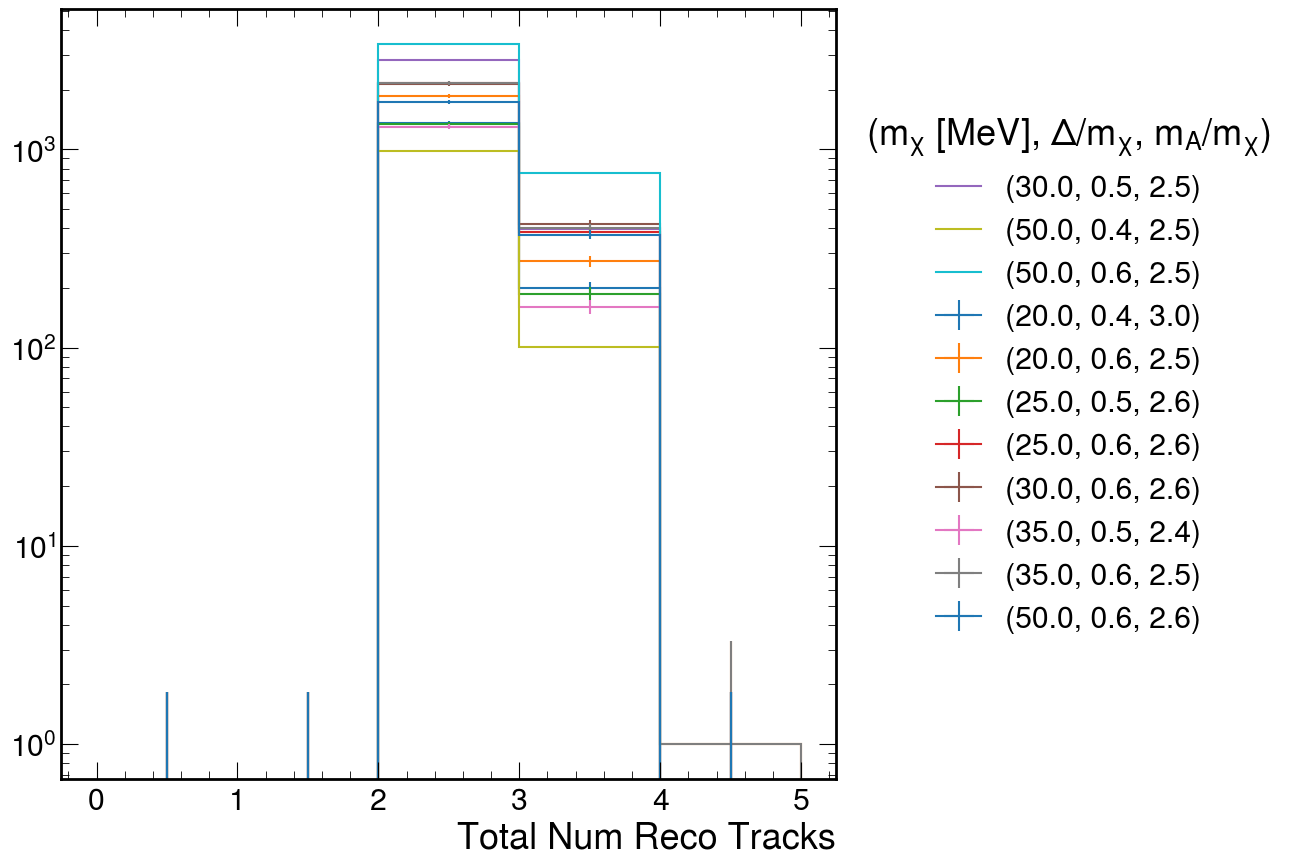

In [154]:
fig, ax = plt.subplots()
# ax.set_prop_cycle(
#     color=colors,
# )

ntracks = [
    (key, val['n_trks'])
    for key, val in out.items()
    if isinstance(key, tuple)
]
ntracks.sort(key = lambda entry : entry[0])

for (mchi, rdmchi, rmap), h in ntracks:
    if rate_maxima[(rate_maxima.mchi==mchi)&(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)].full_rate.iloc[0] > 1.0:
        h.plot(label=f'{(mchi,rdmchi,rmap)}')
plt.legend(
    title='($m_\\chi$ [MeV], $\Delta/m_\\chi$, $m_{A}/m_\\chi$)',
    loc='upper left',
    bbox_to_anchor=(1.,0.9)
)
plt.yscale('log')
plt.savefig('plots/max-reach-over-1-n-tracks.pdf',bbox_inches='tight')
plt.show()